# Anwendung und Vergleich von Machine Learning und Deep Learning Algorithmen zur Vorhersage von COVID-19 Kennzahlen

## Regression
Mit einer Regression werden mit unabhängigen Variabeln $x^{n}$ abhängige Variabeln $y^{n}$ beschrieben. Die unabhängigen Variabeln sind numerisch. 
Die lineare Regression ist die einfachste Art der Regression. Sie geht davon aus, dass die Beziehung zwischen der erklärenden Variable und der Zielvariable linear ist. Wenn keine lineare Beziehung vorliegt, kann ein polynomiales Regressionsmodell angewendet werden. Dabei wird die Zielvariable wie folgt beschrieben, wobei ${d}$ der Grad des Polynoms ist: \
${y = w0 + w1 * x + w2 * x^{2} + ... + wd * x^{d}}$

## Imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA

import plotly.graph_objs as go

%matplotlib inline

## Konfiguration
Auf Windows funtktioniert eine relative Pfadangabe nicht. Darum untenstehende Konfiguration des absoluten Pfades, wo das Projekt unter Windows abgelegt ist. Dies ist unter Linux oder MacOS nicht nötig.


In [124]:
# Path to csv file -> change it locally
# root_path =  "C:/Users/marco/IdeaProjects/ml-corona/"

## Laden der Daten

In [10]:
# Load the data from disk
# Windows: full_dataset = np.load(root_path +'preprocessing/dataset.npy')

full_dataset = np.load('../preprocessing/dataset.npy')

In [11]:
# Move first columns (= cases) to the end of the array
permutations = [1,2,3,4,5,6,7,8,9,10,0]
data = full_dataset[:, permutations]

In [12]:
# Split data in training and test set
num_datapoints = data.shape[0]
num_training = int(num_datapoints*0.7)

train, test = data[:num_training], data[num_training:]

# Verify the shapes of train and test
print(train.shape)
print(test.shape)

(462, 11)
(199, 11)


In [13]:
# Scale the datasets using MinMax scaler (as this scaler transforms the features to a range from 0 to 1 - so all the features have the same range)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

In [14]:
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
print(X_train.shape)
print(y_train.shape)

(462, 10)
(462,)


In [15]:
# Reshape train labels
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [16]:
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]
print(X_test.shape)
print(y_test.shape)

(199, 10)
(199,)


In [17]:
# Reshape test labels
y_test = np.reshape(y_test, (y_test.shape[0], 1))

In [195]:
# pca = PCA(n_components=11)
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.fit_transform(X_test)

## Modelle

### Polynomiale Regression

In [19]:
def create_polynomial_regression_model(degree):
    poly = PolynomialFeatures(degree)
    model = Ridge()

    return poly, model  
    

## Optimales Polynom finden
Um das optimale Polynom zu finden, wird ein Loop über alle untenstehenden Polynome durchgeführt. Pro Polynom wird eine Cross-Validation angewendet (mittels TimesSeriesSplit von sklearn), um damit das beste Modell zu finden.

In [20]:
# List of polynoms to test
polynoms = [2,3,4,5,6,7,8,9,10,11,12]

In [21]:
# Loop over all polynoms
mse_list = []
for i in polynoms:
    poly, model = create_polynomial_regression_model(i)
    
    # Perform cross validation
    splits = TimeSeriesSplit(n_splits=5)
    mse_split_list = []
    for train_index, val_index in splits.split(X_train):
        X_train_split, X_val_split = X_train[train_index], X_train[val_index]
        y_train_split, y_val_split = y_train[train_index], y_train[val_index]

        # Training
        poly_features_train = poly.fit_transform(X_train_split)
        model.fit(poly_features_train, y_train_split)

        # Validation
        poly_features_val = poly.fit_transform(X_val_split)
        y_predicted = model.predict(poly_features_val)
        mse_split = mean_squared_error(y_val_split, y_predicted)
        mse_split_list.append(mse_split)

    mse = sum(mse_split_list) / len(mse_split_list)
    print(f"Polynom {i} mean squared error : {mse}")
    mse_list.append(mse)

Polynom 2 mean squared error : 0.04753507433004027
Polynom 3 mean squared error : 0.0502263453341454
Polynom 4 mean squared error : 0.05156911100857472
Polynom 5 mean squared error : 0.052404004449043216
Polynom 6 mean squared error : 0.05300772839300218
Polynom 7 mean squared error : 0.05342453227206382
Polynom 8 mean squared error : 0.05368125852485878
Polynom 9 mean squared error : 0.05382480292253307
Polynom 10 mean squared error : 0.053901164728504536


KeyboardInterrupt: 

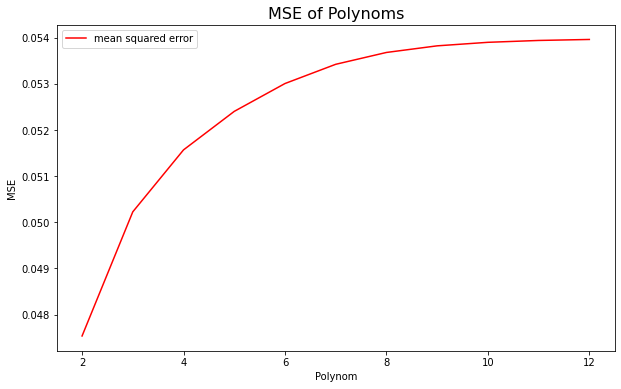

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("MSE of Polynoms", size=16)
plt.plot(polynoms, mse_list, c="red", label='mean squared error')
plt.xlabel("Polynom")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Training des Modells

In [22]:
polynom = 2

In [23]:
poly, model = create_polynomial_regression_model(polynom)
poly_features_train = poly.fit_transform(X_train)
start_time = time.perf_counter()
model.fit(poly_features_train, y_train)
end_time = time.perf_counter()
print(f"Time to train the model was {end_time - start_time:0.4f} seconds")

Time to train the model was 0.0030 seconds


## Evaluation
Evaluierung mit den Testdaten

In [24]:
poly_features_test = poly.fit_transform(X_test)
start_time = time.perf_counter()
y_predicted = model.predict(poly_features_test)
end_time = time.perf_counter()
poly_reg_mse = mean_squared_error(y_test, y_predicted)
print(f"mean squared error {poly_reg_mse}")
print(f"Time to test the model was {end_time - start_time:0.4f} seconds")

mean squared error 0.026608713085042243
Time to test the model was 0.0116 seconds


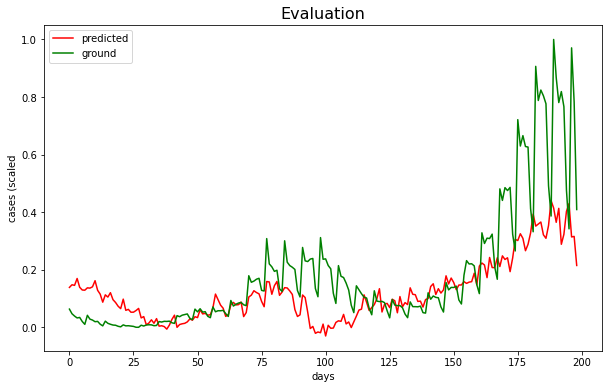

In [25]:
plt.figure(figsize=(10, 6))
plt.title("Evaluation", size=16)
plt.plot(y_predicted, c="red", label='predicted')
plt.plot(y_test, c="green", label='ground')
plt.xlabel("days")
plt.ylabel("cases (scaled")
plt.legend()
plt.show()